In [1]:
import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPooling2D, Activation, 
                          Flatten, Dense, Dropout, BatchNormalization)
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [71]:
# plots images with labels within jupyter notebook
# from https://github.com/smileservices/keras_utils/blob/master/utils.py
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if ims.shape[-1] != 3:
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


In [3]:
import os
print(os.getcwd())
x_path = './hasy-alphanum/alpha_numeric_dataset/alphanum-hasy-data-X.npy'
y_path = './hasy-alphanum/alpha_numeric_dataset/alphanum-hasy-data-Y.npy'
x = np.load(x_path)
y = np.load(y_path)
print('total unique labels', len(np.unique(y)))
x_og = x
num_classes = len(np.unique(y))
# convert labels to be zero-based
for i in range(31, 57):
    y[y == i] -= 31
for i in range(70, 80):
    y[y == i] -= 44
for i in range(90, 109):
    y[y == i] -= 54
for i in range(110, 116):
    y[y == i] -= 55
    
x = x.reshape(x.shape[0], 32, 32 , 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                     random_state=0)
print(len(np.unique(y_train)))
print(np.unique(y_train))

y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)
print(y_train.shape)

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train/=255
x_test/=255

D:\Work\Jupyter
total unique labels 61
61
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60]
(3726, 61)


In [64]:
# save original images for reference
# for img, name in zip(x_og, y):
#     plt.imsave(f'./hasy-alphanum/img/{name}', img) 


(64, 32, 32, 1)
(61,)
[52]
(64, 32, 32)
3726


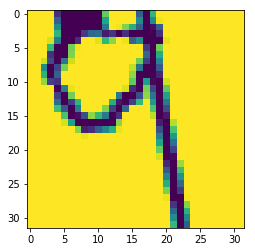

In [126]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.08, 
                         shear_range=0.3, height_shift_range=0.08
                         , channel_shift_range=0.05)
train_batch = gen.flow(x_train, y_train, batch_size=64)
test_batch = gen.flow(x_test, y_test, batch_size=64)
# train_batch = ImageDataGenerator.flow(X, y_train, batch_size=64)
single_img = next(train_batch)
print(single_img[0].shape)
print(single_img[1][0].shape)
print(np.where(single_img[1][0] == 1)[0])
single_img = single_img[0].reshape(single_img[0].shape[0], 32, 32)
print(single_img.shape)
plt.imshow(single_img[0])
print(len(x_train))


In [120]:
# build model
print(x_train.ndim)
print(x_train.shape)
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
# Fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(61))

model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), 
              metrics=['accuracy'])


4
(3726, 32, 32, 1)


In [ ]:
# Train
start_time = time.time()
history = model.fit_generator(train_batch, steps_per_epoch=len(x_train)//64, 
                       epochs=300,
                    validation_data=test_batch, 
                    validation_steps=len(x_test)//64)
elapsed_time = time.time() - start_time
print(f'{elapsed_time:.2f} seconds')


Epoch 1/300
58/58 [==============================] - 29s 499ms/step - loss: 0.0340 - acc: 0.9880 - val_loss: 1.4632 - val_acc: 0.7400
Epoch 2/300
13/58 [=====>........................] - ETA: 20s - loss: 0.0412 - acc: 0.9856

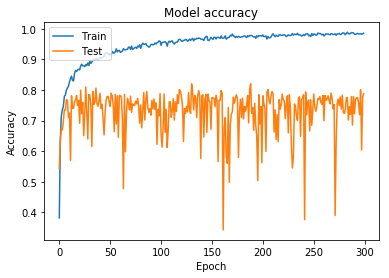

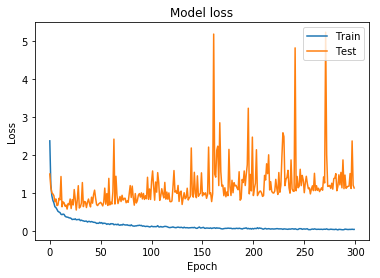

In [122]:
# plot history
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
